<center>
    <h1>The (almost) all-Python QEpy software</h1>
<center>
<br>
<table>
  <tr>
      <td><p><h1>Pavanello Research Group</h1></p><p><h2>Rutgers University-Newark</h2></p></td>
  </tr>
  <tr>
    <td></td>
  </tr>
</table>

#### Quantum MultiScale School June 18th 2024

# Acknowledgements

<table>
  <tr>
      <td><p></p><p>Alina Umerbekova</p><p>Nicolas Viot</p><p>Xin Chen </p><p>Xuecheng Shao</p><p>Michele Pavanello</p><p>Valeria Rios </p><p>Jessica Martinez</p></td>
  </tr>
</table>

Funding: NSF, DOE, MolSSI, ACS-PRF, Rutgers

<center>
QEpy driver: Python driver class for Quantum ESPRESSO - KS-DFT in Python

<br>
<br>

<center>
    <div class="alert alert-success"> GOALS:</div>
    <div class="alert alert-success">1) Get Energy, Volume and bulk modulus by solving the Equation of states (using ASE 'Murnaghan' algorithm) for Aluminum FCC</div>
</center>

#### Getting started!

- Go to QEPy/eos in your tunneled Jupyter-Notebook

<br>
<center>
<h6>./QEPy/eos/QEPY-RISE.ipynb</h6>
</center>

- Run this alongside with me! 

In [1]:
import numpy as np
from ase.build import bulk
from ase.io import read,write
from ase.io.trajectory import Trajectory
import py3Dmol
from qepy.calculator import QEpyCalculator

## Build your system

In [2]:
al = bulk('Al', 'fcc', a=4.05)
write('Al.xyz',al)
v = py3Dmol.view(data=open('./Al.xyz','r').read(), style='sphere')
v.addUnitCell()
v.zoomTo()
v.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Build an 'Input' file

In [3]:
qe_options = {
    '&control': {
        'calculation': "'scf'",
        'pseudo_dir': "'./'",
        'outdir': "tmp",
    },
    '&system': {
        'ibrav' : 0,
        'degauss': 0.005,
        'ecutwfc': 30,
        'nat': 1,
        'ntyp': 1,
        'occupations': "'smearing'",
    },
    'atomic_positions crystal': ['Al    0.0  0.0  0.0'],
    'atomic_species': ['Al  26.98 Al.pbe-nl-kjpaw_psl.1.0.0.UPF'],
    'k_points automatic': ['10 10 10 1 1 1'],
    'cell_parameters angstrom':[
        '0.     2.025  2.025',
        '2.025  0.     2.025',
        '2.025  2.025  0.   '],
}

## Download the Pseupotentials

In [4]:
additional_files = ['http://pseudopotentials.quantum-espresso.org/upf_files/Al.pbe-nl-kjpaw_psl.1.0.0.UPF']
from dftpy.formats import download_files
download_files(additional_files)

## Vary the size of the unit Cell

### Asign the calculator to Al ase atoms Class

In [5]:
# every step will write a new input file, and re-run QE
al.calc = QEpyCalculator(qe_options=qe_options, logfile=True, extrapolation=False)

In [6]:
%%time
traj = Trajectory('tmp.traj', 'w')
cell = al.get_cell()
volumes = []
energies = []
for x in np.linspace(0.9, 1.1, 6):
    al.set_cell(cell * x, scale_atoms=True)
    vol = al.get_volume()
    ene = al.get_potential_energy()
    volumes.append(vol)
    energies.append(ene)
    traj.write(al)

CPU times: user 21 s, sys: 2.84 s, total: 23.9 s
Wall time: 28.1 s


'sj: E: -537.463 eV, V: 16.470 Å$^3$, B: 76.990 GPa'

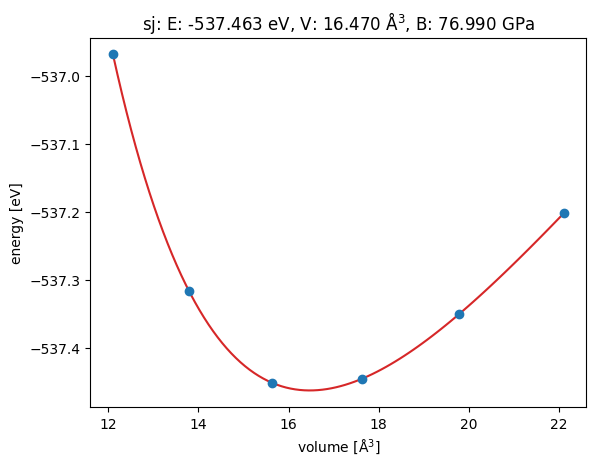

In [7]:
from ase.units import kJ
from ase.eos import EquationOfState
eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit() #
eos.plot('tmp.eos.png').title.get_text()

# Challenge

1. Plot energy vs volume for for Silicon (Diamond, cubic cell, a,b,c = 0.543 nm) or your own system with QEPy.

## Vary the size of the unit cell trick!

In [8]:
al = bulk('Al', 'fcc', a=4.05)
qe_options['&control']['calculation'] = "vc-relax"
al.calc=QEpyCalculator(qe_options=qe_options, logfile=True)

In [9]:
%%time
traj = Trajectory('tmp.traj', 'w')
cell = al.get_cell()
volumes = []
energies = []
for x in np.linspace(0.9, 1.1, 6):
    al.set_cell(cell * x, scale_atoms=True)
    vol = al.get_volume()
    ene = al.get_potential_energy()
    volumes.append(vol)
    energies.append(ene)
    traj.write(al)

CPU times: user 13.9 s, sys: 1.76 s, total: 15.7 s
Wall time: 15.1 s


'sj: E: -537.459 eV, V: 16.452 Å$^3$, B: 77.195 GPa'

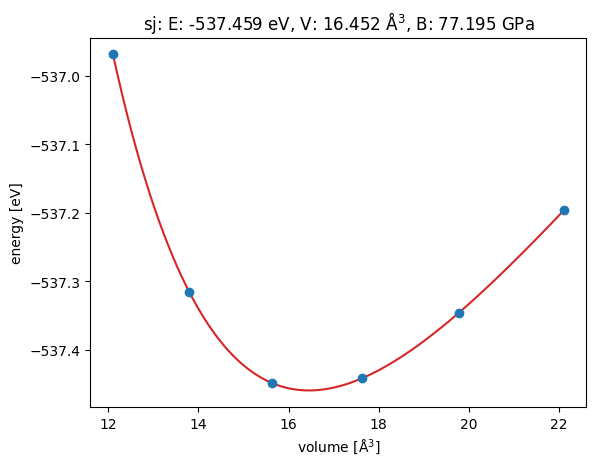

In [10]:
eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
eos.plot('tmp.eos.png').title.get_text()